In [2]:
import numpy as np
import matplotlib.pyplot as plt
from test_parameters import *

In [3]:
def therapy_drug_concentration(N, parameters):

    therapy_type = parameters['therapy_type']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']

    if therapy_type == 'continuous':
        return maximum_tollerated_dose
    if therapy_type == 'notherapy':
        return 0
    elif therapy_type == 'adaptive':
        N0 = parameters['S0'] + parameters['R0']
        if N > 0.5 * N0:
            return maximum_tollerated_dose
        else:
            return 0

In [4]:
def one_step(S, R, time_step, parameters):

    growth_rate_S = parameters['growth_rate_S']
    growth_rate_R = parameters['growth_rate_R']
    carrying_capacity = parameters['carrying_capacity']
    maximum_tollerated_dose = parameters['maximum_tollerated_dose']
    death_rate_S = parameters['death_rate_S']
    death_rate_R = parameters['death_rate_R']
    division_rate = parameters['division_rate']

    N = S + R
    current_carrying_capacity = N / carrying_capacity

    D = therapy_drug_concentration(N, parameters)/maximum_tollerated_dose
    
    effective_growth_rate_S = growth_rate_S * (1 - current_carrying_capacity) * (1 - 2*division_rate*D)
    effective_growth_rate_R = growth_rate_R * (1 - current_carrying_capacity)

    dS = effective_growth_rate_S * S - death_rate_S * S
    dR = effective_growth_rate_R * R - death_rate_R * R

    S1 = S + dS * time_step
    R1 = R + dR * time_step

    return [S1, R1, D]

In [5]:
def two_step(S, R, time_step, parameters):
    
    SR1 = one_step(S, R, time_step/2, parameters)
    SR2 = one_step(SR1[0], SR1[1], time_step/2, parameters)

    return SR2

In [6]:
def ode_model(parameters, verbose=False):


    time_step = parameters['time_step']
    tolerance = parameters['tolerance']

    time_start = parameters['time_start']
    time_end = parameters['time_end']

    S0 = parameters['S0']
    R0 = parameters['R0']
    N0 = S0 + R0
    D0 = 0


    initial_size = int((time_end - time_start) / time_step)

    # Initialize arrays
    S = np.zeros(initial_size)
    R = np.zeros(initial_size)
    N = np.zeros(initial_size)
    T = np.zeros(initial_size)
    D = np.zeros(initial_size)

    current_time = time_start
    current_index = 0

    S[current_index] = S0
    R[current_index] = R0
    N[current_index] = N0
    T[current_index] = current_time
    D[current_index] = D0

    while current_time + time_step < time_end:

        
        SR_1 = one_step(S[current_index], R[current_index], time_step, parameters)
        SR_2 = two_step(S[current_index], R[current_index], time_step, parameters)
        
        error = abs(SR_1[0] - SR_2[0]) + abs(SR_1[1] - SR_2[1])

        if verbose == True:
            print("Error: ", error)
            print("Time step: ", time_step)
            print("Current time: ", current_time)
            print("Tolerance: ", tolerance)
            print("")

        if error < 10 * tolerance:
            S[current_index + 1] = SR_2[0]
            R[current_index + 1] = SR_2[1]
            N[current_index + 1] = S[current_index + 1] + R[current_index + 1]
            T[current_index + 1] = current_time + time_step
            D[current_index + 1] = SR_2[2]
            current_time += time_step
            current_index += 1
            # time_step = time_step/2
        elif error < tolerance:
            S[current_index + 1] = SR_2[0]
            R[current_index + 1] = SR_2[1]
            N[current_index + 1] = S[current_index + 1] + R[current_index + 1]
            T[current_index + 1] = current_time + time_step
            D[current_index + 1] = SR_2[2]
            current_time += time_step
            current_index += 1
        else:
            time_step = time_step/2
        
        if current_index == len(S) - 1:
            S = np.concatenate((S, np.zeros(len(S))))
            R = np.concatenate((R, np.zeros(len(R))))
            N = np.concatenate((N, np.zeros(len(N))))
            T = np.concatenate((T, np.zeros(len(T))))
            D = np.concatenate((D, np.zeros(len(D))))

    SR = two_step(S[current_index], R[current_index], time_end - current_time, parameters)
    S[current_index + 1] = SR[0]
    R[current_index + 1] = SR[1]
    N[current_index + 1] = S[current_index + 1] + R[current_index + 1]
    T[current_index + 1] = time_end
    current_index += 1

    return S[:current_index], R[:current_index], N[:current_index], T[:current_index], D[:current_index]

All tests passed


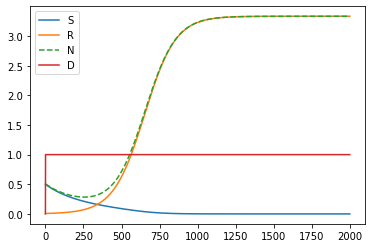

In [13]:
#play around with parameters and maybe have less killing

parameters = {
    'time_start': 0,                                  
    'time_end': 2000,
    'time_step': 0.1,
    'tolerance': 100,
    'S0': 0.5,
    'R0': 0.0075,
    'growth_rate_S': 0.03,
    'growth_rate_R': 0.03,
    'carrying_capacity': 10,
    'maximum_tollerated_dose': 0.8,
    'death_rate_S': 0.03,
    'death_rate_R': 0.02,
    'division_rate': 0.04,
    'therapy_type': 'adaptive'
}

test_parameters(parameters)

S, R, N, T, D = ode_model(parameters, verbose=False)

plt.plot(T, S, label='S')
plt.plot(T, R, label='R')
plt.plot(T, N, label='N', linestyle='--')
plt.plot(T, D, label='D')
plt.legend()
plt.show()